In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import PoissonRegressor

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

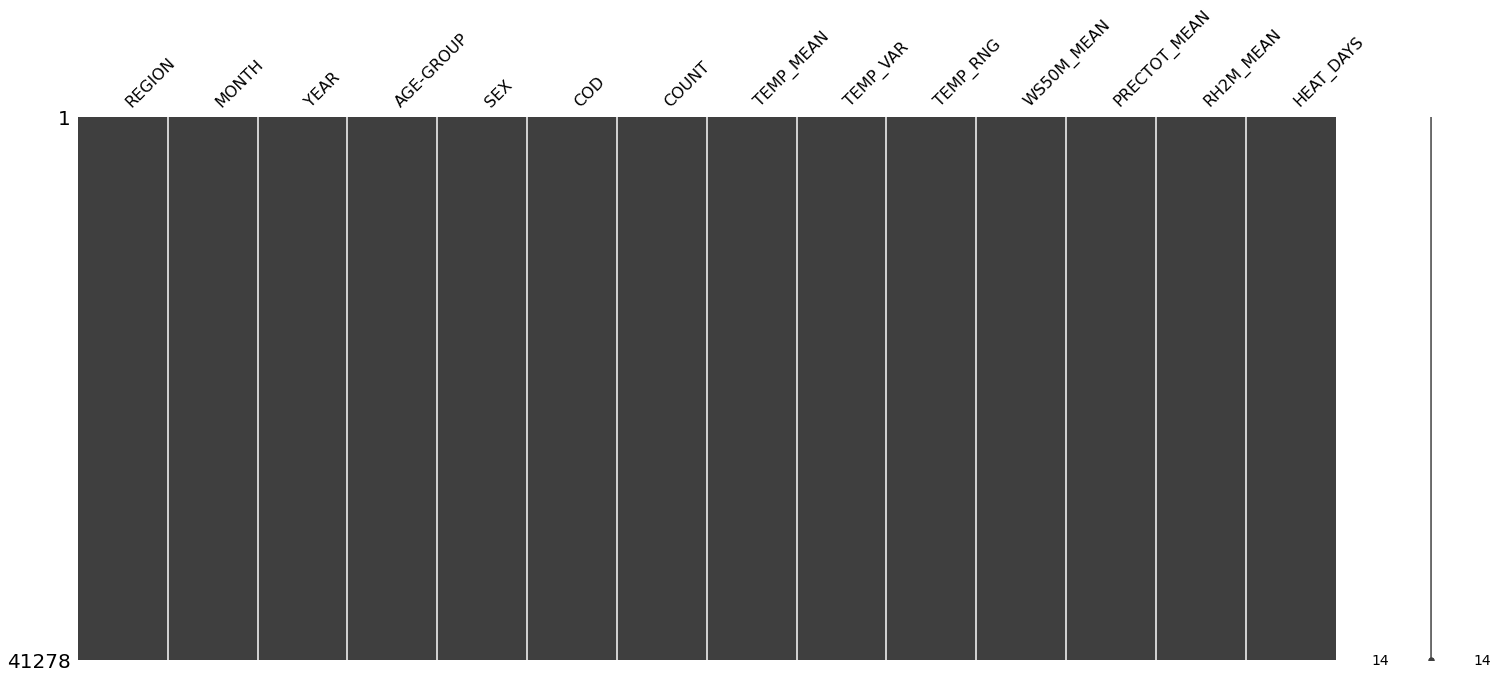

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
# Summer period, comment it out if you want to do for the whole period
def get_summer(df):
    return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]
mortality = get_summer(mortality)

In [5]:
# Train-test split
TEST_SIZE = 0.1
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.drop(categorical_features)

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Parameter grids
n = np.arange(1, 36)
alpha = np.arange(0, 2, 0.05)
params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'dimension_reduction__n_components': n,
         'regressor__alpha': alpha}

In [8]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('dimension_reduction', PCA()),
    ('regressor', PoissonRegressor())
])

In [9]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['MONTH', 'YEAR', 'TEMP_MEAN', 'TEMP_VAR', 'TEMP_RNG', 'WS50M_MEAN',
       'PRECTOT_MEAN', 'RH2M_MEAN', 'HEAT_DAYS'],
      dtype='object')),
                                       

In [10]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_preprocessing__num,param_dimension_reduction__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.066267,0.006976,0.007654,0.005896,0.75,RobustScaler(),17,"{'regressor__alpha': 0.75, 'preprocessing__num...",0.379351,0.336892,0.348555,0.393987,0.346241,0.361005,0.021812,6
1,0.051503,0.003475,0.006844,0.003935,0.05,StandardScaler(),8,"{'regressor__alpha': 0.05, 'preprocessing__num...",0.054091,0.048206,0.045453,0.053785,0.051323,0.050572,0.003319,9
2,0.082204,0.003182,0.008059,0.003121,0.95,RobustScaler(),23,"{'regressor__alpha': 0.9500000000000001, 'prep...",0.589326,0.582048,0.544870,0.554130,0.575521,0.569179,0.016906,5
3,0.045929,0.004678,0.008477,0.003228,1.5,StandardScaler(),32,"{'regressor__alpha': 1.5, 'preprocessing__num'...",0.659384,0.648664,0.639906,0.644074,0.656662,0.649738,0.007360,4
4,0.046347,0.004971,0.009273,0.001010,0.7,RobustScaler(),35,"{'regressor__alpha': 0.7000000000000001, 'prep...",0.751309,0.743226,0.729330,0.739726,0.750818,0.742882,0.008096,1
5,0.092855,0.011026,0.006468,0.004497,0.25,StandardScaler(),25,"{'regressor__alpha': 0.25, 'preprocessing__num...",0.675505,0.681155,0.648666,0.672458,0.684157,0.672388,0.012553,3
6,0.045487,0.004304,0.006847,0.003941,0.5,StandardScaler(),5,"{'regressor__alpha': 0.5, 'preprocessing__num'...",-0.004577,0.005788,0.001748,0.004308,0.001536,0.001761,0.003548,10
7,0.048738,0.003221,0.009250,0.000995,1.3,RobustScaler(),10,"{'regressor__alpha': 1.3, 'preprocessing__num'...",0.052053,0.123417,0.110959,0.118133,0.116514,0.104215,0.026382,8
8,0.062000,0.004341,0.008043,0.003108,0.3,StandardScaler(),14,"{'regressor__alpha': 0.30000000000000004, 'pre...",0.153074,0.153877,0.136770,0.152396,0.143579,0.147939,0.006712,7
9,0.050400,0.000137,0.009654,0.000815,0.7,StandardScaler(),32,"{'regressor__alpha': 0.7000000000000001, 'prep...",0.751068,0.742914,0.729012,0.739564,0.750636,0.742639,0.008127,2


In [11]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__alpha': 0.7000000000000001, 'preprocessing__num': RobustScaler(), 'dimension_reduction__n_components': 35}
Best scores:  0.7428817496061619


In [12]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [13]:
# Test loss
mean_squared_error(y_pred, y_test)

758.1816672020043

In [14]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

659.072225883758

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


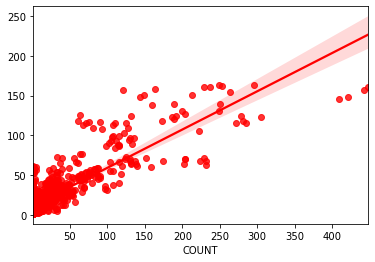

In [15]:
sns.regplot(y_test, y_pred, color = 'red')

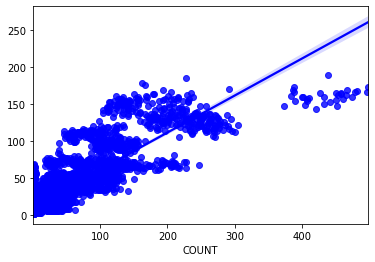

In [16]:
sns.regplot(x = y_train, y = model_chosen.predict(X_train), color = 'blue')